# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #6
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 9th, 2018 at 11:00am

**Instructions:**

- Upload your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Metropolis and Chill

Suppose we ask you to memorize the order of the top five movies on IMDB. When we quiz you on the order afterwards, you might not recall the correct order, but the mistakes you will tend to make in your recall can be modeled by simple probabilistic models.
  
Let's say that the top five movies are:  
1. *The Shawshank Redemption*
2. *The Godfather*
3. *Wonder Woman*
4. *Black Panther*
5. *Pulp Fiction*

Let's represent this ordering by the vector $\omega = (1,2,3,4,5)$. 

If you were to mistakenly recall the top five movies as:
2. *The Godfather*
3. *Wonder Woman*
5. *Pulp Fiction*
4. *Black Panther*
1. *The Shawshank Redemption*

We'd represent your answer by the vector $\theta = (2,3,5,4,1)$.

Now, we have a way of quantifying how wrong your answer can be. We define the Hamming distance between two top five rankings, $\theta, \omega$, as follows:
$$d(\theta, \omega) = \sum_{i=1}^5 \mathbb{I}_{\theta_i\neq \omega_i},$$ 
where $\mathbb{I}_{\theta_i\neq \omega_i}$ is the indicator function that returns 1 if $\theta_i\neq \omega_i$, and 0 otherwise.

For example, the Hamming distance between your answer and the correct answer is $d(\theta, \omega)=4$, because you only ranked *Black Panther* in both answers correctly. 

Finally, let's suppose that the probability of giving a particular answer (expressed as $\theta$) is modeled as
$$ p(\theta \,|\, \omega, \lambda) \propto  e^{-\lambda\, d(\theta,\, \omega)}.$$

### Part A:

Implement an Metropolis algorithm to produce sample guesses from 500 individuals, with various $\lambda$ values, $\lambda=0.2, 0.5, 1.0$. What are the top five possible guesses?

### Part B:
Using the Metropolis algorithm, compute the probability that *The Shawshank Redemption* is ranked as the top movie (ranked number 1) . Compare the resulting probabilities for the various different $\lambda$ values. Summarize your findings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D;
%matplotlib inline

#### Part A

In [2]:
#hamming condition
def hamm(theta,omega=np.array([1,2,3,4,5])):
    count = 0
    for i in range(len(omega)):
        if theta[i] != omega[i]:
            count+=1
    return count

#code adapted from previous hw(5)
def change_tour(input_omega):
    "Change a tour for tsp iteration"
    
    #possible_indices = range(1, len(input_tour)) why not?
    possible_indices = range(len(input_omega))
    # take two random indices to swap
    c1 = np.random.choice(possible_indices)
    c2 = np.random.choice(possible_indices)
    
    new_tour = change_path(input_omega, c1, c2)
    
    return new_tour
     
def swap_cities(input_tour, i, j):
    "Swap two cities at index i and j in a tour"
    
    # save o1
    city1 = input_tour[i]
    
    # save o2
    city2 = input_tour[j]
    
    new_tour = input_tour.copy()
    
    # swap
    new_tour[j] = city1
    new_tour[i] = city2
        
    return new_tour
    
change_path = swap_cities  
    
#sampling distribution
def pdf(theta,lbd):
    return np.exp(-lbd*hamm(theta))

def metropolis(p,lbd, qdraw, nsamp, xinit):
#     samples=np.empty(nsamp)
    samples = []
    x_prev = xinit
    accepted = 0
    for i in range(nsamp):
        x_star = qdraw(x_prev)
#         if i == 0:
#             print(x_star,x_prev)
        p_star = p(x_star,lbd)
        p_prev = p(x_prev,lbd)
        pdfratio = p_star/p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples.append(x_star)
            x_prev = x_star
            accepted += 1
        else:#we always get a sample
            samples.append(x_prev)
            
    return samples, accepted

#### Initial Test with 1 swap

In [3]:
init=np.array([1,2,3,4,5])
random.shuffle(init)
s,a = metropolis(pdf,1,change_tour,500,init)

In [4]:
lvals = [0.2,0.5,1]
avals = []
for i in range(len(lvals)):
    s,a = metropolis(pdf,lvals[i],change_tour,500,init)
    avals.append(a)

Text(0,0.5,'acceptance rate')

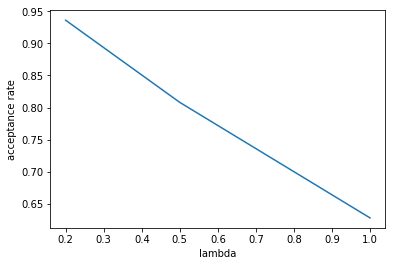

In [5]:
avals = np.array(avals)
plt.plot(lvals,avals/500)
plt.xlabel('lambda')
plt.ylabel('acceptance rate')

Note that there is a very high acceptance rate which means that our effective 'step' isn't large enough. This means one swap is really not doing it. What we need is a larger step size = more swaps. One way to do this is to change our swap function to carry out k swaps where k>=2. If k =5, then we really are doing a random shuffle.

#### Random Shuffle Swap

In [6]:
#k = 2 swaps
def change_tour(input_omega):
    "Change a tour for tsp iteration"
    a = np.copy(input_omega)
    np.random.shuffle(a)
    return a
    

In [7]:
lvals = [0.2,0.5,1]
avals = []
samples = []
for i in range(len(lvals)):
    s,a = metropolis(pdf,lvals[i],change_tour,500,init)
    avals.append(a)
    samples.append(s)

Text(0,0.5,'acceptance rate')

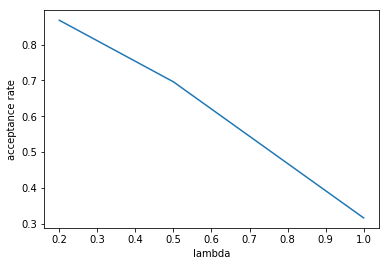

In [8]:
plt.plot(lvals,np.array(avals)/500)
plt.xlabel('lambda')
plt.ylabel('acceptance rate')

So with a random shuffle we really are getting a larger step size which is reflected in the plot above since our acceptance rates are going down!

The question what are the top 5 possible guesses seems independent of our actual sampling algo, therefore I simply use reasoning to answer this and I hope this suffices. To clarify, the hemmings values can only be 0,2,3,4 or 5. The value can never be 1 because if two digits are out of place then we get a hammings value of 2 immediately. Higher errors lead to higher values. Of course a perfect guess is a perfect score. Therefore, any swap of 2 digits in the original sequence will lead to a hammings value of 2.

Below I print out the number of samples with specific hammings values. What I notice is that with all the lambdas, there are on average over 5 samples with hammings values of 0 which means that there are usually 5 people or more who do indeed recall the right sequence.

#### lambda = 0.2

In [9]:
hamvals = []
for i in range(len(samples[0])):
    hamvals.append(hamm(samples[0][i]))
hamvals = np.array(hamvals)

In [10]:
ptr = [0,2,3,4,5]
for i in range(len(ptr)):
    print('# of samples with hamming value of '+str(ptr[i])+' = ' + str(sum(hamvals==ptr[i])))


# of samples with hamming value of 0 = 10
# of samples with hamming value of 2 = 65
# of samples with hamming value of 3 = 108
# of samples with hamming value of 4 = 175
# of samples with hamming value of 5 = 142


#### lambda=0.5

In [11]:
hamvals = []
for i in range(len(samples[1])):
    hamvals.append(hamm(samples[1][i]))
hamvals = np.array(hamvals)
ptr = [0,2,3,4,5]
for i in range(len(ptr)):
    print('# of samples with hamming value of '+str(ptr[i])+' = ' + str(sum(hamvals==ptr[i])))


# of samples with hamming value of 0 = 30
# of samples with hamming value of 2 = 118
# of samples with hamming value of 3 = 98
# of samples with hamming value of 4 = 161
# of samples with hamming value of 5 = 93


#### lambda=1.0

In [12]:
hamvals = []
for i in range(len(samples[2])):
    hamvals.append(hamm(samples[2][i]))
hamvals = np.array(hamvals)
ptr = [0,2,3,4,5]
for i in range(len(ptr)):
    print('# of samples with hamming value of '+str(ptr[i])+' = ' + str(sum(hamvals==ptr[i])))


# of samples with hamming value of 0 = 118
# of samples with hamming value of 2 = 189
# of samples with hamming value of 3 = 121
# of samples with hamming value of 4 = 52
# of samples with hamming value of 5 = 20


## Part B

In [13]:
lvals = [0.2,0.5,1]
for i in range(3):
    ctr = 0
    for j in range(len(samples[i])):
        if samples[i][j][0] == 1:
            ctr+=1
    print('lambda = ' + str(lvals[i]) +',P(Shawshank on top) = '+  str(ctr/len(samples[i])))
            

lambda = 0.2,P(Shawshank on top) = 0.262
lambda = 0.5,P(Shawshank on top) = 0.344
lambda = 1,P(Shawshank on top) = 0.578


So we see that as lambda gets larger, the probability of getting shawshank first gets higher. Why? This is because a larger lambda in this case corresponds to an increased chance of moving to a lower hamming value and a lower chance of moving out of such a minimum.

## Problem 2: Lensed Galaxies via Metropolis-Hastings

You are a renowned observational astronomer working on gravitational lensing and you just got news about a source whose morphology appears distorted, most likely because there is a foreground source (an ensemble of mini black holes for which you know the mass and position) acting as a lens. Your gravitational lensing calculations indicate that the detected flux $F$ from the background source as a function of right ascencion ($x$) and declination ($y$) can be described by a modified Beale's function:

$F(x,y) = \exp\left[-\left(\frac{x^2}{2\sigma_x^2}+\frac{y^2}{2\sigma_y^2}\right)\right] \log (1.0+(1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2) $

with $\sigma_x = \sigma_y = \sqrt{10}$

You are interested in observing this source with the Hubble Space Telescope, and you want to simulate beforehand how photons will form the image on the Hubble detector. You realize that a good way to do this is by sampling F(x,y) with a Monte Carlo method.

### Part A:

Using the following asymmetric function as a proposal distribution:

$q(x,y) = \frac{1}{\sqrt{2 \pi \gamma_1\gamma_2}} {\rm exp}\left[-\left(\frac{(x-0.1)^2}{2 \gamma_1^2} + \frac{(y-0.1)^2}{2 \gamma_2^2}\right) \right] $ 

with $\gamma_1 = 1.0\beta$, $\gamma_2 = 1.5\beta$, and $\beta=1$ (x and y are the coordinates of the proposed step if we center the coordinate system in our current position.)

construct a Metropolis-Hastings algorithm to produce $N=100,000$ samples from $F(x,y)$ with an initial position of $(x,y) = (5,-5)$. Plot the results.

### Part B:

We want to experiment with $\beta$ by running your code with $\beta$ in the range 0.1 to 40 (think about the appropriate order of magnitude of the $\beta$ spacing). 

1. Plot the accepted sample histories for each $\beta$. What is the acceptance rate for each $\beta$? 
2. Explain your results and select the "best" value of $\beta$?

### Part C:

Choose a symmetric proposal and construct a Metropolis algorithm to product $N=100,000$ samples from $F(x,y)$ with an initial position of $(x,y) = (5,-5)$. Plot the results.  How do the results compare to those from Metropolis-Hastings in **Parts A & B**?  

# Solutions

### Part A

In [15]:
import scipy.stats as sp
from scipy.stats import multivariate_normal

In [16]:
sigmax = np.sqrt(10)
sigmay = np.sqrt(10)
#define the distribution we want to sample from
def F(in_vec):
    x = in_vec[0]
    y = in_vec[1]
    return np.exp(-(x**2/(2*sigmax**2)+(y**2/(2*sigmay**2))))*np.log(1+(1.5-x+x*y)**2 + (2.25-x+x*y**2)**2 +(2.625-x+x*y**3)**2)

#define multivariate normal distribution to sample from
def proposal(in_val,b):
    x_old = in_val[0]
    y_old = in_val[1]
    x_new,y_new = multivariate_normal.rvs(mean=[x_old+0.1,y_old+0.1],cov = [[b**2,0],[0,(1.5*b)**2]])
    return [x_new,y_new]

#define multivariate normal pdf check
def q_function(out_val,in_val,b):
    x_old = in_val[0]
    y_old = in_val[1]
    pval = multivariate_normal.pdf(out_val,mean=[x_old+0.1,y_old+0.1],cov = [[b**2,0],[0,(1.5*b)**2]])
    return pval

In [17]:
def metropolis_hastings(p,q, qdraw, nsamp, xinit,b):
    samples=[]
    x_prev = xinit
    accepted=0
    for i in tqdm(range(nsamp)):
        x_star = qdraw(x_prev,b)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        proposalratio = q(x_prev, x_star,b)/q(x_star, x_prev,b)
        if np.random.uniform() < min(1, pdfratio*proposalratio):
            samples.append(x_star)
            x_prev = x_star
            accepted +=1
        else:#we always get a sample
            samples.append(x_prev)
            
    return samples, accepted

#### beta = 1

In [26]:
samples,acc = metropolis_hastings(F,q_function,proposal,100000,[5,-5],1)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [01:47<00:00, 929.79it/s]


In [27]:
print('Acceptance Rate=%s' %(acc/100000))

Acceptance Rate=0.75888


In [27]:
samples = np.array(samples)
#trace plot for x
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])
    
def trcplotter(vec):
    fig,ax = plt.subplots(2,2,figsize=(15,6))
    fig.subplots_adjust(hspace = .5, wspace=.5)
    ax[0,0].plot(vec,alpha=0.3)
    ax[0,0].set_title('All Samples')
    ax[0,1].plot(vec[0:5000],alpha=0.3)
    ax[0,1].set_title('First 5000 Samples')
    ax[1,0].plot(vec[20000:25000],alpha=0.3)
    ax[1,0].set_title('First 5000 Samples after 20000 burnin')
    ax[1,1].plot(vec[20000:25000:10],alpha=.3)
    ax[1,1].set_title('First 5000 after 20000 burnin with 10 samples thinning')

#### Corrplot of X and Y

Text(0.5,1,'Correlation of Y')

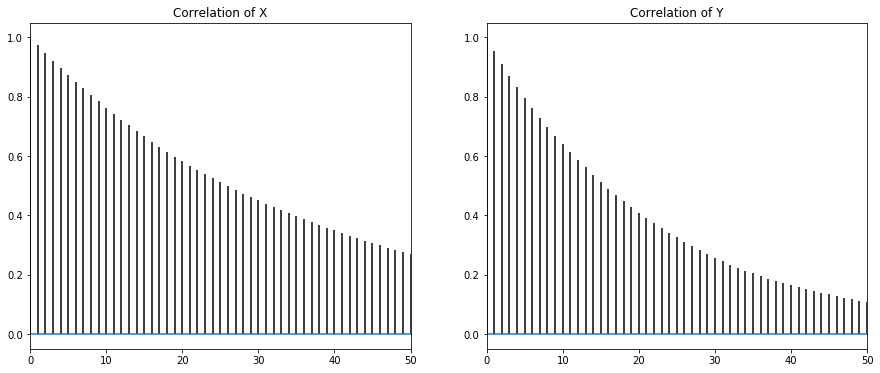

In [39]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
maxlags = 50
ax[0].acorr(samples[:,0]-np.mean(samples[:,0]),normed=True,maxlags=maxlags)
ax[0].set_xlim([0,maxlags])
ax[0].set_title('Correlation of X')
ax[1].acorr(samples[:,1]-np.mean(samples[:,1]),normed=True,maxlags=maxlags)
ax[1].set_xlim([0,maxlags])
ax[1].set_title('Correlation of Y')

We can see that the correlation is decreasing and we can also plot our samples after burnin with some degree of thinning which should get rid of the correlations

Text(0.5,1,'Correlation of Y')

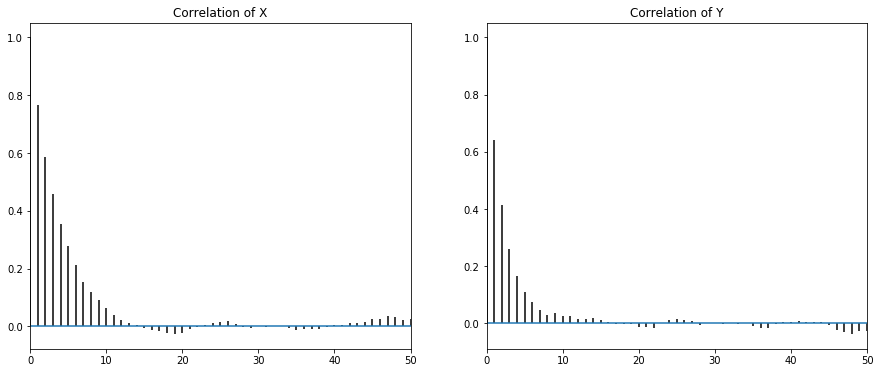

In [41]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
maxlags = 50
burnin=20000
thinning=10
ax[0].acorr(samples[burnin::thinning,0]-np.mean(samples[burnin::thinning,0]),normed=True,maxlags=maxlags)
ax[0].set_xlim([0,maxlags])
ax[0].set_title('Correlation of X')
ax[1].acorr(samples[burnin::thinning,1]-np.mean(samples[burnin::thinning,1]),normed=True,maxlags=maxlags)
ax[1].set_xlim([0,maxlags])
ax[1].set_title('Correlation of Y')

THe plots above indicate that burnin of 20000 and thinning at a rate of 10 samples gets rid of the correlations.

#### Trace Plots for X variable

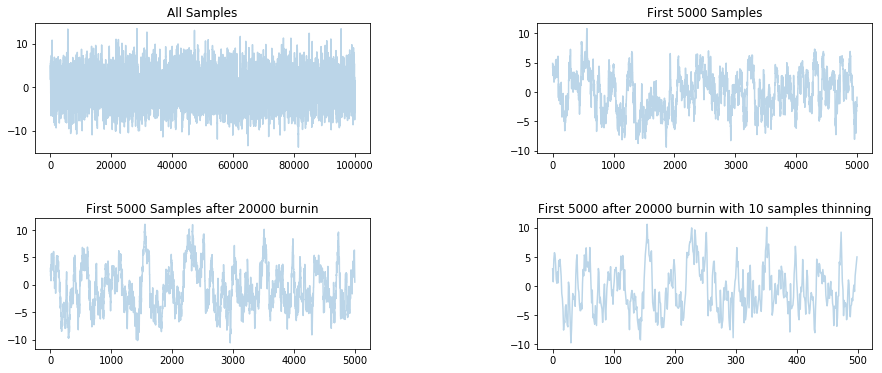

In [29]:
trcplotter(samples[:,0])

#### Trace Plots for Y Variable

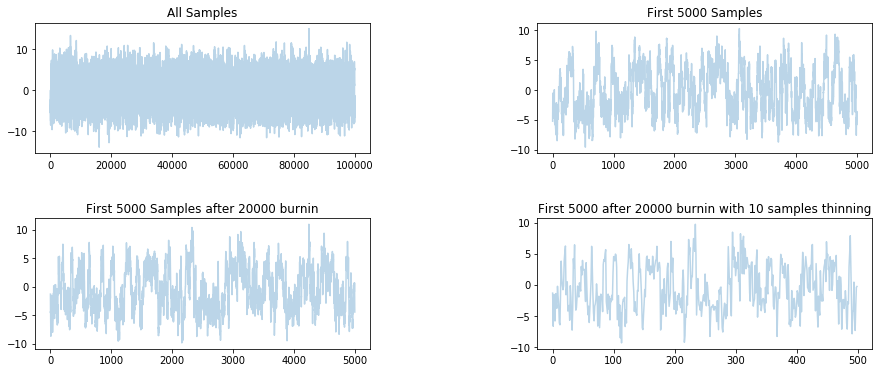

In [30]:
trcplotter(samples[:,1])

We can see that thinning and burnin get us X and Y signals that look like white noise (Bottom right plots).

We can take these thinned samples and plot a histogram to get a sense for what they look like.

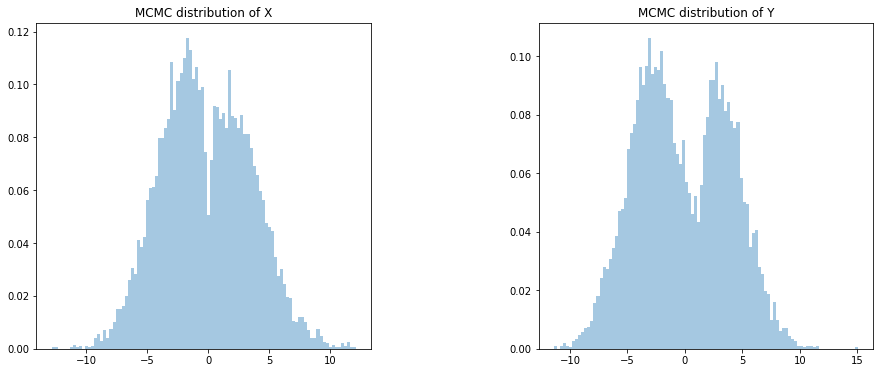

In [31]:
# plot our sample histogram
fig,ax = plt.subplots(1,2,figsize=(15,6))
fig.subplots_adjust(hspace = .5, wspace=.5)

#20000 burnin and 10 thinning
ax[0].hist(samples[20000::10,0],bins=100, alpha=0.4, normed=True) 
ax[0].set_title('MCMC distribution of X')
ax[1].hist(samples[20000::10,1],bins=100, alpha=0.4,  normed=True) 
ax[1].set_title(u'MCMC distribution of Y')

plt.show()


We can also take these samples and visualize what a kde plot of our samples would look like in relation to the actual distribution.

Text(0.5,1,'Actual Distribution')

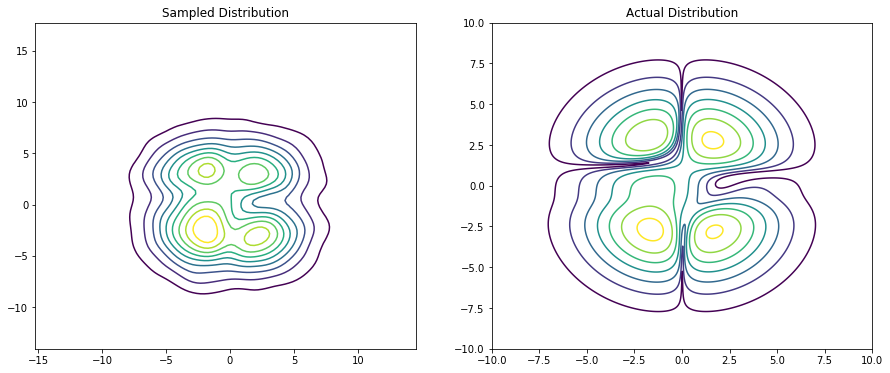

In [32]:
# code adapted from Christian @ https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/
x1 = np.linspace(-10,10,1000)
x2 = np.linspace(-10,10,1000)

# Our 2-dimensional distribution will be over variables X and Y
X = x1
Y = x2
X, Y = np.meshgrid(X, Y)

Z = F([X,Y])

fig,ax = plt.subplots(1,2,figsize=(15,6))
sns.kdeplot(samples[20000::10,0],samples[20000::10,1],cmap='viridis',ax=ax[0])
ax[0].set_title('Sampled Distribution')
ax[1].contour(X, Y, Z, cmap=cm.viridis)
ax[1].set_title('Actual Distribution')


Below I simply plot the 3D visualization for reference.

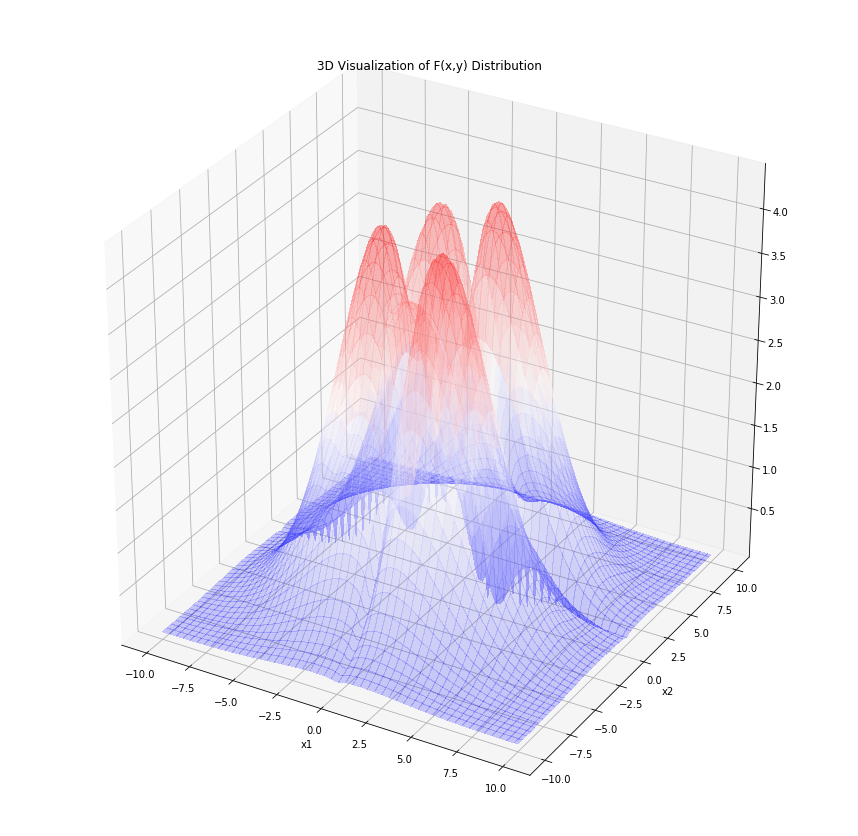

In [87]:
# Create a surface plot and projected filled contour plot under it.
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y, Z, antialiased=False,cmap='bwr',alpha=0.2)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.title('3D Visualization of actual F(x,y) Distribution')
plt.show()

#### Part B

In [18]:
#scan beta around the actual deviation of the distribution F
beta_vals = [0.1,1,3,6,10]
allsamples = []
allaccs = []
for i in range(len(beta_vals)):
    samples,acc = metropolis_hastings(F,q_function,proposal,100000,[5,-5],beta_vals[i])
    allsamples.append(samples)
    allaccs.append(acc)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:48<00:00, 2047.41it/s]


Acceptance plot

Text(0,0.5,'Acceptance Ratio')

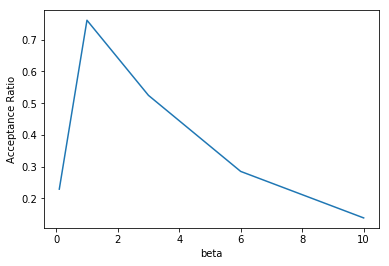

In [19]:
plt.figure()
plt.plot(beta_vals,np.array(allaccs)/100000)
plt.xlabel('beta')
plt.ylabel('Acceptance Ratio')

Note: The trace plots below are all for the X variable. I could have done the same for the Y variable but they are quite similar.

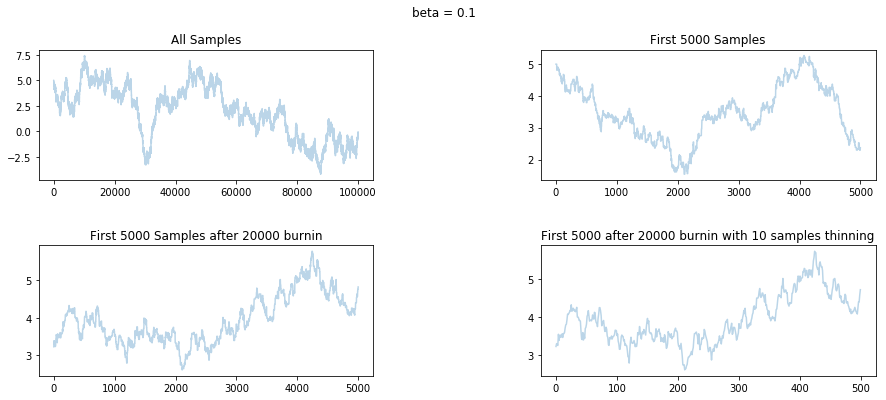

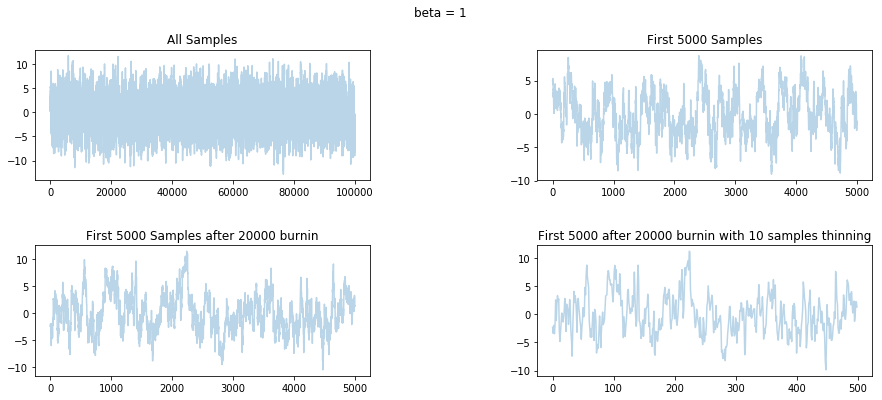

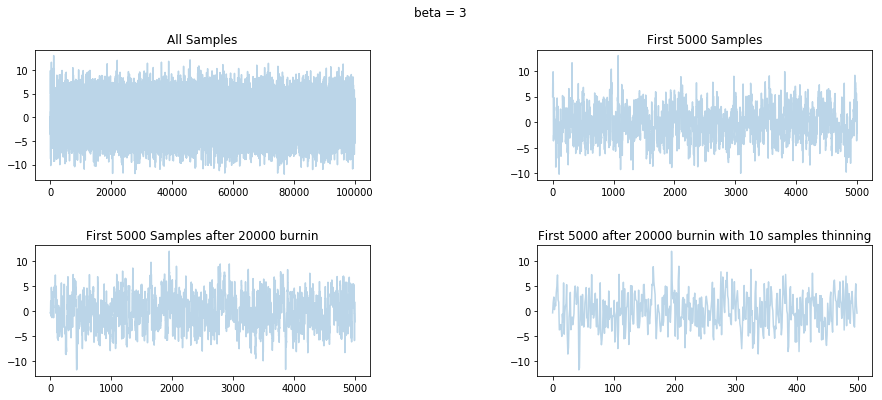

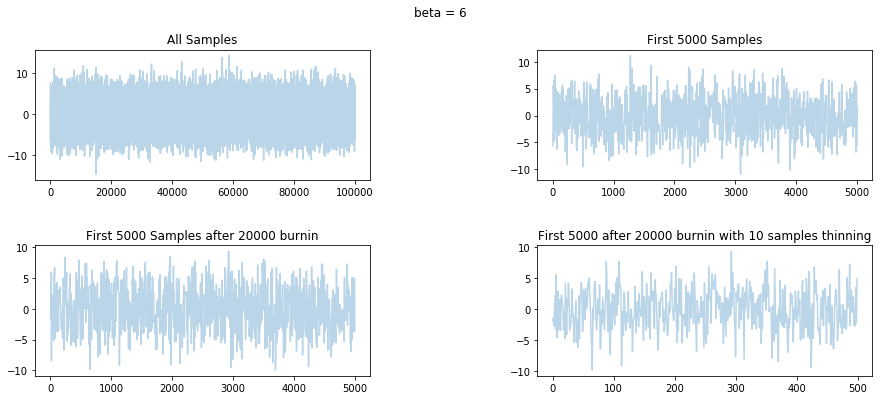

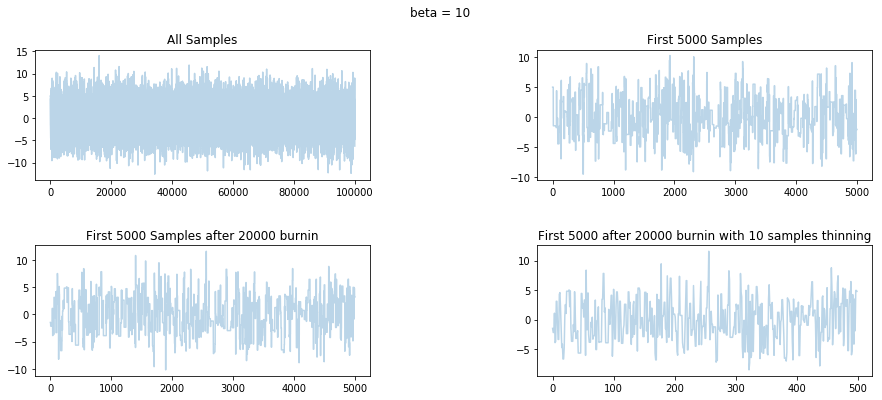

In [20]:
def trcplotter1(vec,bval):
    fig,ax = plt.subplots(2,2,figsize=(15,6))
    fig.subplots_adjust(hspace = .5, wspace=.5)
    fig.suptitle('beta = '+str(bval))
    ax[0,0].plot(vec,alpha=0.3)
    ax[0,0].set_title('All Samples')
    ax[0,1].plot(vec[0:5000],alpha=0.3)
    ax[0,1].set_title('First 5000 Samples')
    ax[1,0].plot(vec[20000:25000],alpha=0.3)
    ax[1,0].set_title('First 5000 Samples after 20000 burnin')
    ax[1,1].plot(vec[20000:25000:10],alpha=.3)
    ax[1,1].set_title('First 5000 after 20000 burnin with 10 samples thinning')
    
for i in range(len(beta_vals)):
    trcplotter1(np.array(allsamples[i])[:,0],beta_vals[i])
    

Correlation plots of X can also be made. They are made with 20,000 burnin and a thinning rate of 10.

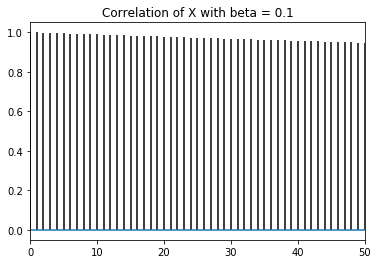

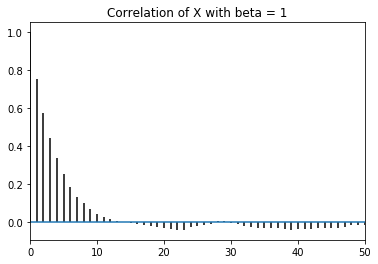

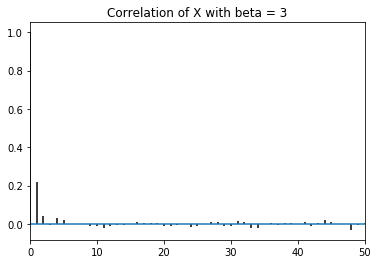

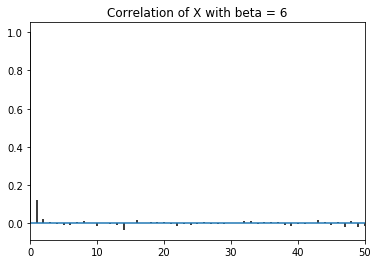

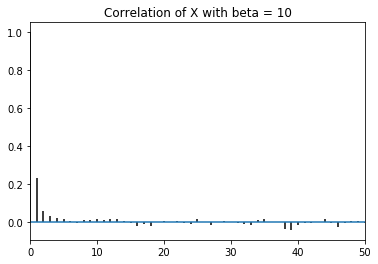

In [21]:
for i in range(len(beta_vals)):
    maxlags = 50
    burnin=20000
    thinning=10
    plt.figure()
    plt.acorr(np.array(allsamples[i])[burnin::thinning,0]-np.mean(np.array(allsamples[i])[burnin::thinning,0]),normed=True,maxlags=maxlags)
    plt.xlim([0,maxlags])
    plt.title('Correlation of X with beta = '+str(beta_vals[i]))

Using our correlation plots and the trace plots + the acceptance ratio, we can argue that beta between 3 and 6 would be good. This actually corresponds to having a deviation of x similar to that of the deviation of the distribution we want to sample from.

The reason values in that range are good is because their acceptance ratio is relatively low e.g. 30-40% which means the stepsizes are probably reasonable. Furthermore, the trace plots after burnin and thinning look more like white noise than really small beta's or really large betas.

#### Part C

My implementation below is equivalent in most ways to MH with the caveat that my proposal is now symmetric with values in the covariance matrix that are the same along the diagonal.

In [22]:
sigmax = np.sqrt(10)
sigmay = np.sqrt(10)
#define the distribution we want to sample from
def F(in_vec):
    x = in_vec[0]
    y = in_vec[1]
    return np.exp(-(x**2/(2*sigmax**2)+(y**2/(2*sigmay**2))))*np.log(1+(1.5-x+x*y)**2 + (2.25-x+x*y**2)**2 +(2.625-x+x*y**3)**2)

#define SYMMETRIC multivariate normal distribution to sample from
def proposal(in_val,b):
    x_old = in_val[0]
    y_old = in_val[1]
    x_new,y_new = multivariate_normal.rvs(mean=[x_old,y_old],cov = [[b**2,0],[0,(b)**2]])
    return [x_new,y_new]


def metropolis(p, qdraw, nsamp, xinit,bval):
#     samples=np.empty(nsamp)
    samples = []
    x_prev = xinit
    accepted = 0
    for i in range(nsamp):
        x_star = qdraw(x_prev,bval)
#         if i == 0:
#             print(x_star,x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples.append(x_star)
            x_prev = x_star
            accepted += 1
        else:#we always get a sample
            samples.append(x_prev)
            
    return samples, accepted

In [23]:
s,a = metropolis(F,proposal,100000,[5,-5],np.sqrt(10))

In [24]:
print('sigma = '+str(np.sqrt(10)))
print('acceptance ratio = '+str(a/100000))

sigma = 3.1622776601683795
acceptance ratio = 0.57313


In [25]:
samples = np.array(s)

X samples


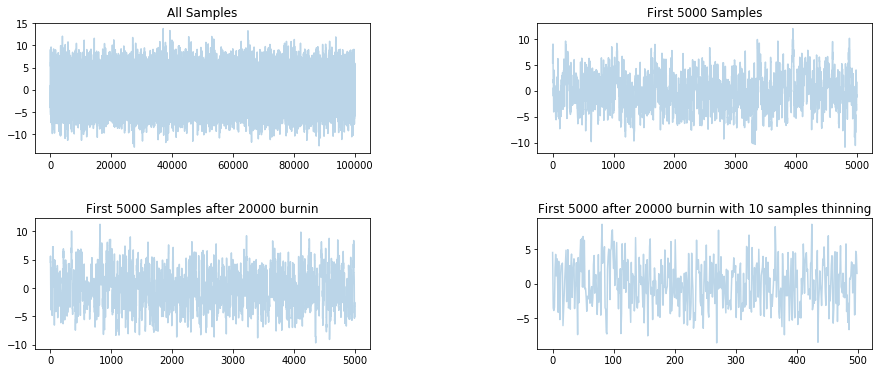

In [28]:

trcplotter(samples[:,0])
print('X samples')

Y Samples


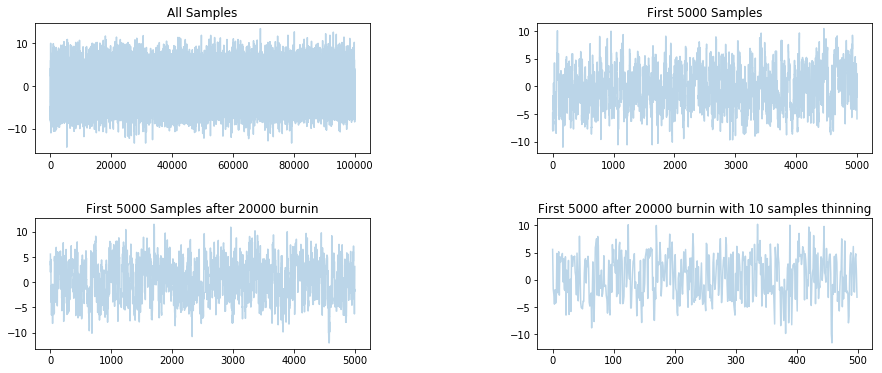

In [29]:
trcplotter(samples[:,1])
print('Y Samples')

Correlation Plots

Text(0.5,1,'Correlation of Y')

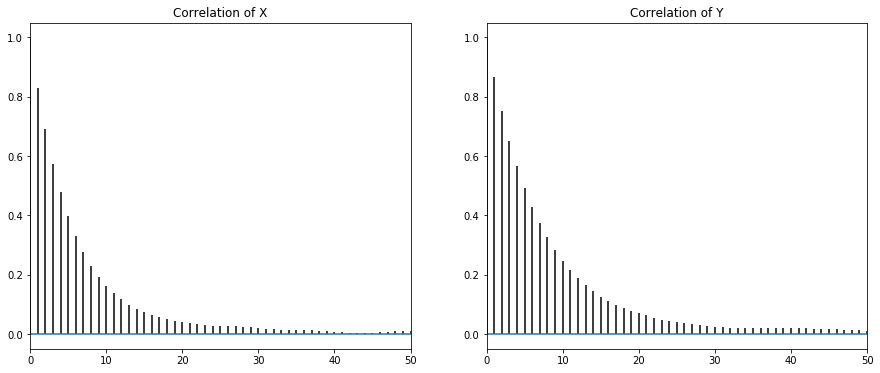

In [30]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
maxlags = 50
ax[0].acorr(samples[:,0]-np.mean(samples[:,0]),normed=True,maxlags=maxlags)
ax[0].set_xlim([0,maxlags])
ax[0].set_title('Correlation of X')
ax[1].acorr(samples[:,1]-np.mean(samples[:,1]),normed=True,maxlags=maxlags)
ax[1].set_xlim([0,maxlags])
ax[1].set_title('Correlation of Y')

Correlation seems to die out without burnin or thinning as was needed in MH with beta = 1.
Trace plots show some correlation but not as poor as MH with beta = 0.1. 

It seems evident that both MH and Metropolis can do a relatively good job here as long as they have the right parameters. One allows us to sample from an asymettric distribution while the other allows us to do the same using a symmetric. MH gives us a chance to use an asymmetric proposal seems to be the key difference.